In [1]:
import pandas as pd
import numpy as np
%matplotlib inline


from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

path = "../files/"

In [2]:
#Leitura do dataset filtrado
df = pd.read_csv( path + "4mula_filtered.csv" )
#Coleta do corpus filtado
corpus = df['filtered_lyrics']
corpus = corpus[0:1000]

In [3]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    AgglomerativeClustering(affinity='cosine', linkage='average')
    
pipeline = pipeline.fit(corpus)
model = pipeline.named_steps['agglomerativeclustering']

In [6]:
pipeline

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7f8333471ca0>)),
                ('agglomerativeclustering',
                 AgglomerativeClustering(affinity='cosine',
                                         linkage='average'))])

In [4]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

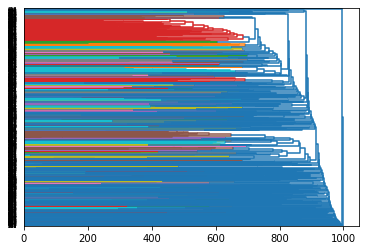

In [5]:
plot_dendrogram(model, labels=corpus.index, orientation='right')
